Using device: cuda
Starting improved training with linear sparsity schedule...
Pruning method: Global Unstructured Pruning
Epoch 1: Warm-up phase (no pruning)


/tmp/ipython-input-2006743408.py:376: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if torch.cuda.is_available() else None
/tmp/ipython-input-2006743408.py:249: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.301358	Acc: 8.59%
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.967520	Acc: 23.61%
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.925610	Acc: 28.95%
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.682172	Acc: 33.03%

Test set: Average loss: 1.5922, Accuracy: 5039/10000 (50.39%)

Epoch 2: Warm-up phase (no pruning)
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.672514	Acc: 47.66%
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.587883	Acc: 50.90%
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.589500	Acc: 52.08%
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.391782	Acc: 53.38%

Test set: Average loss: 1.4281, Accuracy: 5900/10000 (59.00%)

Epoch 3: Warm-up phase (no pruning)
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.404482	Acc: 58.59%
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.247322	Acc: 58.60%
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.210743	Acc: 59.99%
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.411153	Acc: 60.82%

Test set: Average loss: 1.2561, Accuracy: 6656/10000 (66.56%)

Epoch 4:

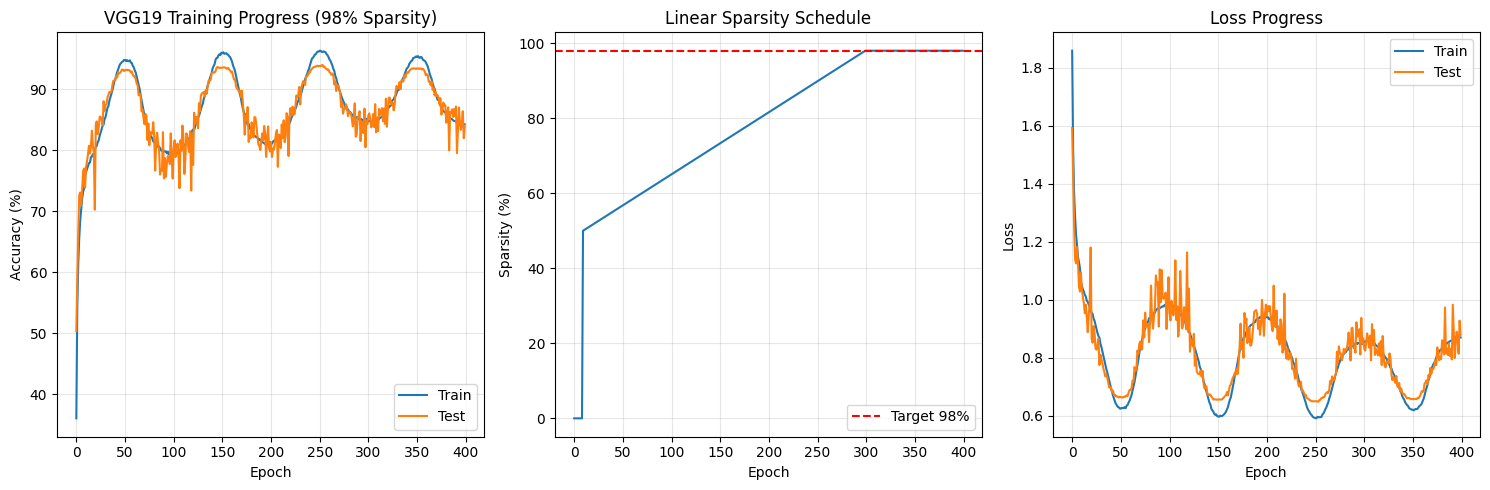

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ PDF downloaded to your computer!

Final Results:
Best overall accuracy: 93.98%
Best accuracy at >97% sparsity: 93.44%


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR
from torch.cuda.amp import autocast, GradScaler
import math

# Enhanced VGG19 with improved mask application and layer-wise sparsity
class ImprovedDynamicSparseVGG19(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedDynamicSparseVGG19, self).__init__()
        self.masks = {}  # Store masks for each layer
        self.layer_importance = {}  # Store importance scores for layers

        # VGG19 configuration: 'M' means MaxPool2d
        cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

        self.features = self._make_layers(cfg)

        # Enhanced Classifier with better regularization
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),  # Reduced dropout for better gradient flow
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),  # Added BatchNorm
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),  # Added BatchNorm
            nn.ReLU(True),
            nn.Linear(512, num_classes),
        )

        # Better initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                          nn.BatchNorm2d(x),
                          nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

    def apply_masks(self):
        """Apply masks to weights during forward pass"""
        if not hasattr(self, 'masks') or not self.masks:
            return
        with torch.no_grad():
            for name, param in self.named_parameters():
                mask = self.masks.get(name, None)
                if mask is not None:
                    param.mul_(mask)

    def forward(self, x):
        # Apply masks before forward pass
        self.apply_masks()
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

# Enhanced pruning functions with layer-wise sparsity
def compute_layer_wise_sparsity(model, base_sparsity, layer_importance_scores=None):
    """Compute layer-wise sparsity based on layer sensitivity"""
    layer_sparsities = {}

    # Default importance scores (empirically determined for VGG)
    if layer_importance_scores is None:
        layer_importance_scores = {
            'features.0': 0.7,   # First conv layer - less sparsity
            'features.3': 0.85,
            'features.7': 0.9,
            'features.10': 0.95,
            'features.14': 0.95,
            'features.17': 0.98,
            'features.20': 0.98,
            'features.24': 0.98,
            'features.27': 0.98,
            'features.30': 0.98,
            'features.34': 0.98,
            'features.37': 0.98,
            'features.40': 0.98,
            'features.44': 0.98,
            'features.47': 0.98,
            'features.50': 0.98,
            'classifier.1': 0.95,
            'classifier.4': 0.95,
            'classifier.7': 0.9,  # Last layer - less sparsity
        }

    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            # Adjust sparsity based on layer importance
            if name in layer_importance_scores:
                layer_sparsities[name + '.weight'] = min(layer_importance_scores[name], base_sparsity)
            else:
                layer_sparsities[name + '.weight'] = base_sparsity

    return layer_sparsities

def create_magnitude_based_masks_improved(model, sparsity_dict, use_gradient_info=False, gradients=None):
    """Enhanced UNSTRUCTURED magnitude-based pruning (element-wise like original)"""
    masks = {}

    for name, param in model.named_parameters():
        if 'weight' in name and name in sparsity_dict:
            sparsity = sparsity_dict[name]

            # Compute importance scores
            if use_gradient_info and gradients is not None and name in gradients:
                # Combine magnitude and gradient information
                importance = torch.abs(param.data) * torch.abs(gradients[name])
            else:
                importance = torch.abs(param.data)

            # UNSTRUCTURED pruning for all layers (element-wise)
            flattened = importance.flatten()
            num_params = flattened.shape[0]
            num_pruned = int(num_params * sparsity)

            if num_pruned > 0 and num_pruned < num_params:
                # Find threshold for this layer
                sorted_importance, _ = torch.sort(flattened)
                threshold = sorted_importance[num_pruned]
                mask = (importance >= threshold).float()
            elif num_pruned >= num_params:
                # Prune everything (shouldn't happen with proper sparsity values)
                mask = torch.zeros_like(param)
            else:
                # Keep everything
                mask = torch.ones_like(param)

            masks[name] = mask

    return masks

def create_global_magnitude_masks(model, target_sparsity):
    """Global magnitude pruning (exactly like your original approach)"""
    all_weights = []
    param_info = []

    # Gather all weights
    for name, param in model.named_parameters():
        if 'weight' in name and param.dim() > 1:
            all_weights.append(param.data.abs().flatten())
            param_info.append((name, param))

    if not all_weights:
        return {}

    # Concatenate all weights and find global threshold
    all_weights_concat = torch.cat(all_weights)
    total_params = all_weights_concat.numel()
    num_to_prune = int(total_params * target_sparsity)

    if num_to_prune > 0:
        sorted_weights, _ = torch.sort(all_weights_concat)
        threshold = sorted_weights[num_to_prune]
    else:
        threshold = 0

    # Create masks based on global threshold
    masks = {}
    for name, param in param_info:
        mask = (param.data.abs() >= threshold).float()
        masks[name] = mask

    return masks

def linear_sparsity_schedule(current_epoch, total_epochs, initial_sparsity, target_sparsity):
    """Linear sparsity schedule as requested"""
    progress = current_epoch / total_epochs
    current_sparsity = initial_sparsity + (target_sparsity - initial_sparsity) * progress
    return min(current_sparsity, target_sparsity)

# Label smoothing loss
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, x, target):
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

# Knowledge distillation helper
class KnowledgeDistillationLoss(nn.Module):
    def __init__(self, temperature=4.0, alpha=0.7):
        super(KnowledgeDistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.criterion_kd = nn.KLDivLoss(reduction='batchmean')
        self.criterion_ce = LabelSmoothingCrossEntropy(smoothing=0.1)

    def forward(self, student_logits, teacher_logits, labels):
        # Distillation loss
        soft_targets = F.softmax(teacher_logits / self.temperature, dim=1)
        soft_predictions = F.log_softmax(student_logits / self.temperature, dim=1)
        distillation_loss = self.criterion_kd(soft_predictions, soft_targets) * (self.temperature ** 2)

        # Standard cross-entropy loss
        ce_loss = self.criterion_ce(student_logits, labels)

        # Combined loss
        total_loss = self.alpha * distillation_loss + (1 - self.alpha) * ce_loss
        return total_loss

def train_improved(model, device, train_loader, optimizer, epoch, criterion, scaler=None, use_amp=True):
    """Enhanced training function with mixed precision"""
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        if use_amp and scaler is not None:
            with autocast():
                output = model(data)
                loss = criterion(output, target)

            scaler.scale(loss).backward()

            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()
        else:
            output = model(data)
            loss = criterion(output, target)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\t'
                  f'Loss: {loss.item():.6f}\tAcc: {100.*correct/total:.2f}%')

    return train_loss / len(train_loader), 100. * correct / total

def test_improved(model, device, test_loader, criterion):
    """Enhanced testing function"""
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / total
    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{total} ({accuracy:.2f}%)\n')

    return test_loss, accuracy

def calculate_sparsity(model):
    """Calculate current model sparsity"""
    total_params = 0
    zero_params = 0

    for name, param in model.named_parameters():
        if 'weight' in name:
            total_params += param.numel()
            zero_params += (param == 0).sum().item()

    sparsity = 100. * zero_params / total_params
    return sparsity

# Main training function
def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Hyperparameters (optimized for better accuracy)
    batch_size = 128
    epochs = 400  # Increased epochs for better convergence
    initial_lr = 0.1
    momentum = 0.9
    weight_decay = 5e-4
    target_sparsity = 0.98
    initial_sparsity = 0.5  # Start with lower sparsity
    pruning_start_epoch = 10  # Warm-up before pruning
    pruning_end_epoch = 300  # Stop pruning earlier to allow recovery

    # Enhanced data augmentation
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.33)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    # Load CIFAR-10 dataset
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,
                                              num_workers=4, pin_memory=True, drop_last=True)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False,
                                             num_workers=4, pin_memory=True)

    # Initialize model
    model = ImprovedDynamicSparseVGG19(num_classes=10).to(device)

    # Use label smoothing loss
    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

    # Optimizer with better settings
    optimizer = torch.optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum,
                               weight_decay=weight_decay, nesterov=True)

    # Learning rate scheduler - Cosine Annealing with Warm Restarts
    scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-4)

    # Mixed precision training
    scaler = GradScaler() if torch.cuda.is_available() else None

    # Training history
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    sparsities = []

    best_accuracy = 0
    best_sparse_accuracy = 0

    # Choose pruning strategy
    use_global_pruning = True  # Using GLOBAL pruning for consistency with your other codes

    print(f"Starting improved training with linear sparsity schedule...")
    print(f"Pruning method: {'Global' if use_global_pruning else 'Layer-wise'} Unstructured Pruning")

    for epoch in range(1, epochs + 1):
        # Linear sparsity schedule (as requested)
        if epoch >= pruning_start_epoch and epoch <= pruning_end_epoch:
            current_sparsity = linear_sparsity_schedule(
                epoch - pruning_start_epoch,
                pruning_end_epoch - pruning_start_epoch,
                initial_sparsity,
                target_sparsity
            )

            # Create and apply masks
            if use_global_pruning:
                # Global unstructured pruning (like your original)
                model.masks = create_global_magnitude_masks(model, current_sparsity)
            else:
                # Layer-wise unstructured pruning with sensitivity
                layer_sparsities = compute_layer_wise_sparsity(model, current_sparsity)
                model.masks = create_magnitude_based_masks_improved(model, layer_sparsities)

            model.apply_masks()

            actual_sparsity = calculate_sparsity(model)
            print(f'Epoch {epoch}: Target Sparsity: {current_sparsity*100:.2f}%, '
                  f'Actual Sparsity: {actual_sparsity:.2f}%')
        elif epoch > pruning_end_epoch:
            # Fine-tuning phase - keep masks but allow remaining weights to adapt
            model.apply_masks()
            actual_sparsity = calculate_sparsity(model)
            print(f'Epoch {epoch}: Fine-tuning with Sparsity: {actual_sparsity:.2f}%')
        else:
            actual_sparsity = 0
            print(f'Epoch {epoch}: Warm-up phase (no pruning)')

        # Train
        train_loss, train_acc = train_improved(model, device, train_loader, optimizer,
                                              epoch, criterion, scaler, use_amp=torch.cuda.is_available())

        # Test
        test_loss, test_acc = test_improved(model, device, test_loader, criterion)

        # Update learning rate
        scheduler.step()

        # Save history
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        sparsities.append(actual_sparsity)

        # Track best accuracy
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'masks': model.masks,
                'accuracy': test_acc,
                'sparsity': actual_sparsity,
            }, 'best_model.pth')

        if actual_sparsity >= 97 and test_acc > best_sparse_accuracy:
            best_sparse_accuracy = test_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'masks': model.masks,
                'accuracy': test_acc,
                'sparsity': actual_sparsity,
            }, 'best_sparse_model.pth')

    print(f"\nTraining completed!")
    print(f"Best accuracy: {best_accuracy:.2f}%")
    print(f"Best accuracy at >97% sparsity: {best_sparse_accuracy:.2f}%")

    # Plot results - 3 side-by-side graphs
    plt.figure(figsize=(15, 5))

    # Left: Accuracy vs Epoch (Train and Test)
    plt.subplot(1, 3, 1)
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('VGG19 Training Progress (98% Sparsity)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Middle: Linear Sparsity Schedule
    plt.subplot(1, 3, 2)
    plt.plot(sparsities)
    plt.axhline(y=98, color='r', linestyle='--', label='Target 98%')
    plt.xlabel('Epoch')
    plt.ylabel('Sparsity (%)')
    plt.title('Linear Sparsity Schedule')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Right: Loss vs Epoch (Train and Test)
    plt.subplot(1, 3, 3)
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('improved_training_results.pdf', dpi=300, bbox_inches='tight')
    plt.show()

    # Download the PDF file
    try:
        from google.colab import files
        files.download('improved_training_results.pdf')
        print("✓ PDF downloaded to your computer!")
    except Exception as e:
        print(f"⚠️ Could not auto-download: {e}")
        print("Run this in a new cell: files.download('improved_training_results.pdf')")


    return model, best_accuracy, best_sparse_accuracy

if __name__ == "__main__":
    model, best_acc, best_sparse_acc = main()
    print(f"\n{'='*50}")
    print(f"Final Results:")
    print(f"Best overall accuracy: {best_acc:.2f}%")
    print(f"Best accuracy at >97% sparsity: {best_sparse_acc:.2f}%")
    print(f"{'='*50}")